In [87]:
import Pkg
Pkg.activate("MD_simulation/")
using Plots, Parameters, Printf, Unitful, LaTeXStrings, Printf

In [89]:
# Physical constants in proper units
const kB = 0.0019872041               # kcal/(mol·K)
const amu_to_kg = 1.66053906660e-27   # kg/amu
const kcal_to_J = 4184.0              # J/kcal
const angstrom_to_m = 1e-10
const ps_to_s = 1e-12
const NA = 6.02214076e23              # Avogadro's number
const J_to_kcal = 1/4184.0            # 1 J = 0.000239 kcal

# data structures
@with_kw struct AtomID
    name::String
    σ::Float64    # Å
    ε::Float64    # kcal/mol
    mass::Float64 # amu
end

@with_kw mutable struct MDinput
    box_size::Vector{Float64}  # Å
    temperature::Float64       # K
    total_time::Float64        # ps
    dt::Float64                # ps
    cutoff::Float64 = 15.0     # Å
    nsteps::Int = trunc(Int, total_time/dt)
end

@with_kw mutable struct AtomState
    id::AtomID
    r::Vector{Float64}  # Å
    v::Vector{Float64}  # Å/ps
    f::Vector{Float64}  # kcal/(mol·Å)
    f_prev::Vector{Float64} = zeros(length(r))
end

@with_kw mutable struct Simulation
    atoms::Vector{AtomState}
    input::MDinput
    current_step::Int = 0
    time::Float64 = 0.0
    trajectory::Vector{Vector{Tuple{String,Vector{Float64}}}} = []
    log_interval::Int = 100
end


Simulation

In [90]:
function setRectangular(input::MDinput, atoms::Vector{AtomID}, dims::Vector{Int}; noise=0.1)
    positions = []
    spacing = input.box_size ./ dims
    
    particle = 1
    for i in CartesianIndices(Tuple(dims))
        pos = [spacing[d] * (i[d] - 0.5) for d in 1:length(input.box_size)]
        
        # Add noise if requested
        if noise > 0
            pos .+= noise .* randn(length(pos))
        end
        
        push!(positions, (pos, atoms[mod1(particle, length(atoms))]))
        particle += 1
    end
    return positions
end

setRectangular (generic function with 1 method)

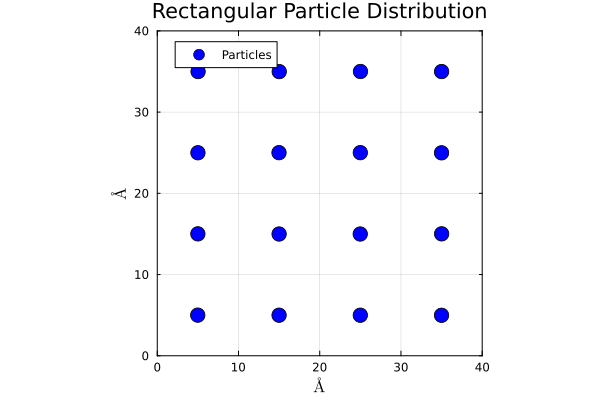

In [91]:
#=
ar = AtomID(name="Ar", σ=3.4, ε=0.238, mass=39.948)
he = AtomID(name="He", σ=2.64, ε=0.083, mass=4.002)


md = MDinput(
    box_size=[50.0, 50.0],  # 5σ box
    temperature=100.0,
    total_time=1.0,         # 100 fs
    dt=0.0001,              # 0.1 fs steps
    cutoff=10.0)

positions = setRectangular(md, [ar, he], [5, 5], noise=0.01)



# Separate positions by atom type
x_ar = [pos[1] for (pos, atom) in positions if atom.name == "Ar"]
y_ar = [pos[2] for (pos, atom) in positions if atom.name == "Ar"]

x_he = [pos[1] for (pos, atom) in positions if atom.name == "He"]
y_he = [pos[2] for (pos, atom) in positions if atom.name == "He"]

# Create the plot with differentiated atoms
scatter(x_ar, y_ar,
    label = "Argon",
    title = "Particle Distribution (Ar + He)",
    xlabel = L"\textrm{\AA}",
    ylabel = L"\textrm{\AA}",
    aspect_ratio = :equal,
    markersize = 8,
    markercolor = :blue,
    markershape = :circle,
    markerstrokecolor = :black,
    
    xlims = (0, md.box_size[1]),
    ylims = (0, md.box_size[2]),
    framestyle = :box,
    legend = :topright
)

scatter!(x_he, y_he,
    label = "Helium",
    markersize = 6,
    markercolor = :red,
    markershape = :square,
    markerstrokecolor = :black
)

=#



ar = AtomID(name="Ar", σ=3.4, ε=0.238, mass=39.948)

md = MDinput(
    box_size=[50.0, 50.0],  # 5σ box
    temperature=100.0,
    total_time=1.0,         # 100 fs
    dt=0.0001,              # 0.1 fs steps
    cutoff=10.0)

positions = setRectangular(md, [ar], [5, 5], noise=0.01)

x = [pos[1]  for (pos, atom) in positions]
y = [pos[2]  for (pos, atom) in positions]

# Create the plot
scatter(x, y,
    label = "Particles",
    title = "Rectangular Particle Distribution",
    xlabel = L"\textrm{\AA}",
    ylabel = L"\textrm{\AA}",
    aspect_ratio = :equal,  # Keep axis scales equal
    markersize = 8,
    markercolor = :blue,
    xlims = (0, 40),
    ylims = (0, 40),
    framestyle=:box

)


In [92]:

function minimum_image(rx, L)
    if rx >= L/2
        rx -= L
    elseif rx < -L/2
        rx += L
    end
    return rx
end

function apply_minimum_image!(dr, box)
    for d in eachindex(dr)
        dr[d] = minimum_image(dr[d], box[d])
    end
    return dr
end

#=

# Test 1: Simple wrap
@assert minimum_image(0.7, 1.0) ≈ -0.3
@assert minimum_image(-0.7, 1.0) ≈ 0.3

# Test 2: Edge cases
@assert minimum_image(0.5, 1.0) ≈ -0.5  # Exact boundary
@assert minimum_image(-0.5, 1.0) ≈ -0.5  # Maintains position

# Test 3: Vector handling
dr = [0.7, -0.7]
apply_minimum_image!(dr, [1.0, 1.0])
@assert dr ≈ [-0.3, 0.3]

Original: -0.7 ──────●────────── 0.7
Adjusted:  0.3 ────●──────────── -0.3
          (-0.5)              (0.5)


=#


apply_minimum_image! (generic function with 1 method)

In [93]:

function pair_lj(r, atom1::AtomID, atom2::AtomID)
  #= Lorentz-Berthelot mixing rules - it will reduce to 1 for the same atom
     even if this is terrible from the performance point of view, it will be done this way for the first version.
     the improvements of the code will be also used as a way to study more MD, since the used programs are quite well optimized, being
     complicated to understand all steps... 
  =#
  σ_mix = (atom1.σ + atom2.σ)/2
  ε_mix = sqrt(atom1.ε * atom2.ε)
  # lj calculation
  σ6 = (σ_mix)^6
  σ12 = (σ6)^2
  inv_r6 = (1/r)^6
  inv_r12 = inv_r6^2

  return 4.0 * ε_mix * (σ12 * inv_r12 - σ6 * inv_r6)
end


function utotal_lj(positions, md::MDinput)
  energy = 0.0
  n = length(positions)
  cutoff_sq = md.cutoff^2

  for i in 1:n
      (pos_i, atom_i) = positions[i]
      for j in (i+1):n
          (pos_j, atom_j) = positions[j]

          rij = pos_i .- pos_j # calculate the displacement vector
          apply_minimum_image!(rij, md.box_size) # apply minimum_image in all dimensions
          r2 = sum(rij.^2) # distance between two points!

          # check if r2 is smaller than the cutoff and avoid self-interaction
          if r2 < cutoff_sq && r2 > 0.0
            energy += pair_lj(r2,atom_i, atom_j)
          end

      end
  end
  return energy
end

utotal_lj(positions, md)

-4.0257768346284394e-8

In [94]:
atoms = [AtomState(id=atom, r=pos, v=zeros(2), f=zeros(2)) for (pos, atom) in positions]
sim = Simulation(atoms=atoms, input=md, log_interval=10)

Simulation
  atoms: Array{AtomState}((25,))
  input: MDinput
  current_step: Int64 0
  time: Float64 0.0
  trajectory: Array{Vector{Tuple{String, Vector{Float64}}}}((0,))
  log_interval: Int64 10


In [95]:
function initialize_velocities!(sim::Simulation)
    T = sim.input.temperature
    total_mass = 0.0
    total_momentum = zeros(length(sim.atoms[1].v))  # [0.0, 0.0] for 2D

    # Physical constants in proper units
    kB = 0.0019872041  # kcal/(mol·K)
    amu_to_kg = 1.66053906660e-27  # kg/amu
    J_per_kcal = 4184.0
    NA = 6.02214076e23  # Avogadro's number

    for atom in sim.atoms
        # Convert mass to kg
        mass_kg = atom.id.mass * amu_to_kg
        
        # Calculate thermal velocity (SI units)
        σ_v = sqrt((kB * J_per_kcal * T) / (mass_kg * NA))  # m/s
        
        # Convert to Å/ps (1 m/s = 0.01 Å/ps)
        σ_v_angps = σ_v * 0.01
        
        # Initialize velocities
        atom.v .= σ_v_angps .* randn(length(atom.r))
        
        # Accumulate for COM calculation
        total_mass += atom.id.mass
        total_momentum .+= atom.id.mass .* atom.v
    end

    # Remove center-of-mass velocity
    v_cm = total_momentum ./ total_mass
    for atom in sim.atoms
        atom.v .-= v_cm
    end
end

initialize_velocities! (generic function with 1 method)

In [96]:
initialize_velocities!(sim)

In [97]:
function compute_forces!(atoms::Vector{AtomState},md::MDinput)
    
    # setting zero for the forces in the beggining
    for atom in atoms
        atom.f .= 0.0
    end
    
    cutoff_sq = (md.cutoff)^2
    for i in 1:length(atoms), j in i+1:length(atoms)
        a1 = atoms[i]
        a2 = atoms[j]
        
        dr = a1.r - a2.r
        dr .= minimum_image.(dr, md.box_size)
        
        r2 = sum(dr.^2)
        if r2 > cutoff_sq || r2 == 0
            continue
        end
        
        r = sqrt(r2)
        σ = (a1.id.σ + a2.id.σ)/2
        ε = sqrt(a1.id.ε * a2.id.ε)
        
        # Force in kcal/(mol·Å)
        force = (24 * ε / σ) * (2*(σ/r)^13 - (σ/r)^7)
        
        a1.f .-= force .* dr
        a2.f .+= force .* dr
    end
end

compute_forces! (generic function with 1 method)

In [98]:


function verlet_step!(sim::Simulation)
    dt = sim.input.dt
    J_to_kcal = 1/4184.0
    amu_to_kg = 1.66053906660e-27
    NA = 6.02214076e23

    # Update positions and half-step velocities
    for atom in sim.atoms
        # Convert mass to kcal·ps²/(Å²·mol)
        mass = atom.id.mass * amu_to_kg * NA * 1e4 * J_to_kcal
        
        # Update positions: r(t+Δt) = r(t) + v(t)Δt + 0.5a(t)Δt²
        atom.r .+= atom.v .* dt + 0.5 .* atom.f ./ mass .* dt^2
        
        # Half-step velocity update: v(t+Δt/2) = v(t) + 0.5a(t)Δt
        atom.v .+= 0.5 .* atom.f ./ mass .* dt
    end

    # Compute new forces
    compute_forces!(sim.atoms, md)#sim.input.box_size, sim.input.cutoff)

    # Complete velocity update
    for atom in sim.atoms
        mass = atom.id.mass * amu_to_kg * NA * 1e4 * J_to_kcal
        atom.v .+= 0.5 .* atom.f ./ mass .* dt
    end

    sim.time += dt
    sim.current_step += 1
end

verlet_step! (generic function with 1 method)

In [ ]:
#calculation of temperature, energy and other control variables

function get_positions(sim::Simulation)
    return [(atom.r, atom.id) for atom in sim.atoms]
end


function energy_calc(sim::Simulation, md::MDinput)
    J_to_kcal = 1/4184.0
    amu_to_kg = 1.66053906660e-27
    NA = 6.02214076e23

    pos = get_positions(sim)

    pe = utotal_lj(pos, md)
    
    ke = 0.0
    for atom in sim.atoms
        mass = atom.id.mass * amu_to_kg * NA * 1e4 * J_to_kcal
        ke += 0.5 * mass * sum(atom.v.^2)
    end
    
    return pe + ke, pe, ke
end





function temperature(sim::Simulation)
    kB = 0.0019872041  # kcal/(mol·K)
    J_to_kcal = 1/4184.0
    amu_to_kg = 1.66053906660e-27
    NA = 6.02214076e23

    ke = 0.0
    for atom in sim.atoms
        # Proper mass conversion (kcal·ps²/(Å²·mol))
        mass = atom.id.mass * amu_to_kg * NA * 1e4 * J_to_kcal
        ke += 0.5 * mass * sum(atom.v.^2)
    end
    
    dof = 2*length(sim.atoms) - 2  # 2D degrees of freedom
    (2 * ke) / (dof * kB)
end


temperature (generic function with 1 method)

In [102]:
function save_trajectory!(sim::Simulation)
    frame = Tuple{String,Vector{Float64}}[]
    for atom in sim.atoms
        # Convert back to real units for storage
        pos_real = atom.r .* sim.input.unit_system.σ_ref
        push!(frame, (atom.id.name, pos_real))
    end
    push!(sim.trajectory, frame)
end


function write_xyz(sim::Simulation, filename="traj.xyz")
    open(filename, "w") do io  # Changed from 'as' to 'do'
        for frame in sim.trajectory
            write(io, "$(length(frame))\n")  # Fixed missing parenthesis
            write(io, "Step $(sim.current_step), Time $(sim.time)\n")
            for (name, pos) in frame
                # Ensure 3D coordinates (add 0.0 for Z if 2D)
                x = pos[1] * sim.input.unit_system.σ_ref  # Convert to Å
                y = pos[2] * sim.input.unit_system.σ_ref
                write(io, "$name $x $y 0.0\n")
            end
        end
    end  # Added closing 'end' for the 'do' block
end

write_xyz (generic function with 2 methods)

In [108]:
function run!(sim::Simulation, md::MDinput)
    # Initial velocities
    initialize_velocities!(sim)  

    # Initial forces
    compute_forces!(sim.atoms, md)
     
    while sim.current_step < sim.input.nsteps
        verlet_step!(sim)
        
        # Save trajectory and log datrun!(sim)a
        if sim.current_step % sim.log_interval == 0
            #save_trajectory!(sim)
            
            T = temperature(sim)
            E_total, E_pot, E_kin = energy_calc(sim, md)
            
            @printf("Step %6d: T = %.2f K, E_total = %.3f, E_pot = %.3f, E_kin = %.3f\n",
                   sim.current_step,
                   T,  # Convert back to K
                   E_total, E_pot, E_kin)

            #@printf("Step %6d: T = %.2f K\n", sim.current_step, T)
        end
    end
    
    #write_xyz(sim)
end

run! (generic function with 2 methods)

In [ ]:

ar = AtomID(name="Ar", σ=3.4, ε=0.238, mass=39.948)

md = MDinput(
    box_size=[50.0, 50.0],  # 5σ box
    temperature=300.0,
    total_time=1.0,         # 100 fs
    dt=0.0001,              # 0.1 fs steps
    cutoff=10.0)

positions = setRectangular(md, [ar], [10, 10], noise=0.01)
atoms = [AtomState(id=atom, r=pos, v=zeros(2), f=zeros(2)) for (pos, atom) in positions]
sim = Simulation(atoms=atoms, input=md, log_interval=10)
run!(sim, md)